# Neural Style Transfer

***Neural style transfer*** is an optimization technique used to take two images - a ***target image*** and a ***style image*** (such as an artwork by a famous painter) - and blend them together so the output image looks like the target image, but “painted” in the style of the style reference image.


### Loss definition

  The resulting image ***x**** minimizes a weighted sum of three losses: 
  
  * the content loss L-content(cc,xx)
  * the style loss L-style(ss,xx)
  * the total variation loss L-total-variation(xx).

***x**** =argminxx(αL-content(cc,xx) + βL-style(ss,xx) + γL-total-variation(xx))

Where:
* xx: generated image.
* cc: content image.
* ss: reference style image.
* α, β and γ: weights.

### Content loss
* for a layer = distance between the feature maps of the content and generated images

### The style loss

* Style = low-level features of an image (textures, colors, visual patterns).
* Can be captured by using correlations across the different feature maps (filter responses) of a convnet.
* Feature correlations are computed via a Gram matrix (outer product of the feature maps for a given layer).
* Style loss for a layer = distance between the Gram matrices of the feature maps for the style and generated images.

### The total variation loss

* Sum of the absolute differences for neighboring pixel-values in an image. Measures how much noise is in the image.
* Encourage local spatial continuity in the generated image (denoising).
* Act as a regularization loss.

### Gradient descent

* Objective: minimize the total loss.
* Optimizer: L-BFGS (original choice made by Gatys et al.) or Adam.

### VGG-19

VGG-19 is a convolutional neural network that is trained on more than a million images from the ImageNet database [1]. The network is 19 layers deep and can classify images into 1000 object categories, such as a keyboard, mouse, pencil, and many animals. As a result, the network has learned rich feature representations for a wide range of images.

## References:

* [Neural style transfer](https://www.bpesquet.fr/mlhandbook/algorithms/neural_style_transfer.html)
* [Documentations](https://arxiv.org/abs/1508.06576)

- Deep Learning with Python, François Chollet

## Imports

In [8]:
import numpy as np

import tensorflow as tf

from tensorflow.keras import Model
from tensorflow.keras.applications import vgg19
from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing.image import load_img, save_img, img_to_array
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from pathlib import Path

from IPython.display import Image, display

In [67]:
target = Path('./data/face4.jpg')
style = Path('./data/Best Artworks of All Time/resized/Vasiliy Kandinsky/Vasiliy_Kandinskiy_6.jpg')

## Preprocess

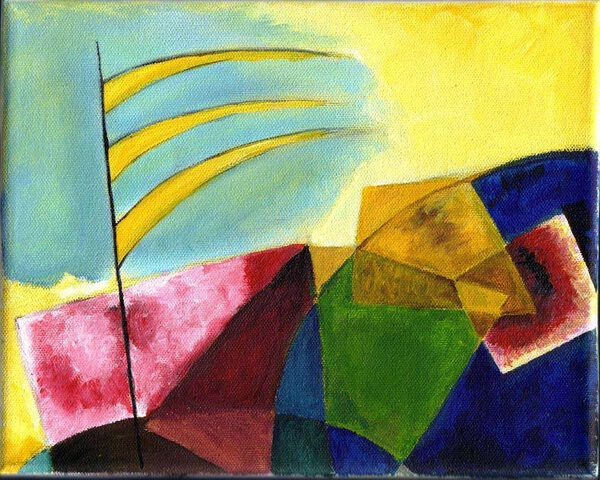

In [68]:
# Display image

display(Image(style))

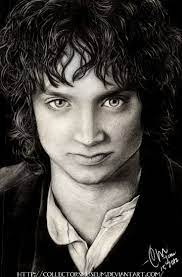

In [69]:
# Display target

display(Image(target))

In [70]:
# Dimensions of the generated picture.

width, height = load_img(target).size
img_height = 400
img_width = int(width * img_height / height)

In [71]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)

In [72]:
# Preprocess images

target_img = preprocess_image(target)
style_img = preprocess_image(style)
combination_image = tf.Variable(preprocess_image(target))

## Model

In [73]:
# We build the VGG19 network with our batch of 3 images as input.

# Build a VGG19 model loaded with pre-trained ImageNet weights
vgg = vgg19.VGG19(weights="imagenet", include_top=False)

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in vgg.layers])

# Set up a model that returns the activation values for every layer in VGG19 as a dict.
feature_extractor = Model(inputs=vgg.inputs, outputs=outputs_dict)

In [74]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

## Loss Computation

In [75]:
# Name of layer used for the content loss
content_layer_name = 'block5_conv2'

# Name of layers used for style loss
style_layer_names = ['block1_conv1','block2_conv1','block3_conv1', 'block4_conv1', 'block5_conv1']

# Weights in the weighted average of the loss components
# total_variation_weight = 1e-4
# style_weight = 1.
# content_weight = 0.025

# Weights of the different loss components
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

In [76]:
# Let’s define the content loss, meant to make sure that the top layer of the VGG19
# convnet will have a similar view of the target image and the generated image:
#  The content loss, operating on the features of the target image and
# the generated "combination" image

def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))

# Now, here’s the style loss. It leverages an auxiliary function to compute the Gram
# matrix of an input matrix, i.e. a map of the correlations found in the original feature
# matrix.
#  The style loss, operating on the features of the style reference image
# and the generated "combination" image

def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))


# To these two loss components, we add a third one, the "total variation loss". It is
# meant to encourage spatial continuity in the generated image, thus avoiding overly
# pixelated results. You could interpret it as a regularization loss.

def total_variation_loss(x):
    a = tf.square(x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])  
    b = tf.square(x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
    return tf.reduce_sum(tf.pow(a + b, 1.25))

The loss that we minimize is a weighted average of these three losses. To compute the
content loss, we only leverage one top layer, the layer, while for the style block5_conv2
loss we use a list of layers than spans both low-level and high-level layers. We add the
total variation loss at the end.
Depending on the style reference image and content image you are using, you will
likely want to tune the coefficient, the contribution of the content loss content_weight
to the total loss. A higher content_weight means that the target content will be more
recognizable in the generated image

In [77]:
def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat([base_image, style_reference_image, combination_image], axis=0)
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(base_image_features, combination_features)
    
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

In [78]:
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

## Training

In [80]:
# e, a single iteration represents 20 steps of gradient ascent):

optimizer = SGD(ExponentialDecay(initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96))

epoch = 150
for i in range(1, epoch + 1):
    loss, grads = compute_loss_and_grads(combination_image, target_img, style_img)
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 10 == 0:
        print(f"Epoch [{i}/{epoch}], loss: {loss:.2f}")

Epoch [10/150], loss: 41951.00
Epoch [20/150], loss: 9464.29
Epoch [30/150], loss: 7866.76
Epoch [40/150], loss: 6051.32
Epoch [50/150], loss: 5973.20
Epoch [60/150], loss: 4334.00
Epoch [70/150], loss: 4620.57
Epoch [80/150], loss: 4990.05
Epoch [90/150], loss: 3387.49
Epoch [100/150], loss: 3563.34
Epoch [110/150], loss: 4337.42
Epoch [120/150], loss: 3028.18
Epoch [130/150], loss: 2848.90
Epoch [140/150], loss: 3195.45
Epoch [150/150], loss: 3805.36


## Converting back

In [81]:
# Function to convert a tensor to a valid image

def deprocess_image(x, height, width):
    x = x.reshape((height, width, 3))
    # Remove zero-center by mean pixel applied by vgg19.preprocess_input()
    # The following values are the mean pixel values of each color channel for the ImageNet dataset
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

In [82]:
# Deprocess and Save final image

final_img = deprocess_image(combination_image.numpy(), img_height, img_width)
result_image_path = f"generated_image_epoch_{epoch}.png"
save_img(result_image_path, final_img)

## Dsiplay

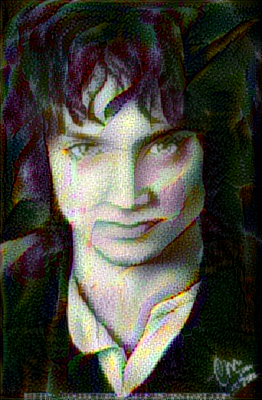

In [83]:
# Show final generated image
display(Image(result_image_path))